In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
!nvidia-smi

Tue Nov 24 07:41:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:2D:00.0  On |                  N/A |
|  0%   48C    P0    27W / 140W |    809MiB /  6077MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=26732 sha256=a1b354843d119aae68e41a014b794d89043ba3e7f95d9c1b528842d7a0e6ad0f
  Stored in directory: /root/.cache/pip/wheels/27/4d/3a/6dcdf7c3ebc87bf1ae013d96c9cf060ccfe334bb5ee769f377
Successfully built imutils
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

In [ ]:
# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [7]:
dataset_loc = "./Alzheimers_Dataset"
train_images = list(paths.list_images(dataset_loc+"/train"))

In [10]:
len(train_images)

5121

In [11]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [12]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [13]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [73]:
# Create TensorFlow dataset
BATCH_SIZE = 16

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [74]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [66]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/augmentation/gaussian_filter.py

--2020-11-24 07:58:35--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.40.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘helpers.py.2’

helpers.py.2        100%[===================>]     891  --.-KB/s    in 0.007s  

2020-11-24 07:58:35 (120 KB/s) - ‘helpers.py.2’ saved [891/891]

--2020-11-24 07:58:36--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.40.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘losses.py.2’

losses.py.2         100%[===================>]     891  --.-KB/s    in

In [67]:
# %load helpers.py
# remove "augmentation."
# %writefile helpers.py
import tensorflow as tf
import numpy as np
from gaussian_filter import GaussianBlur


def get_negative_mask(batch_size):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)


def gaussian_filter(v1, v2):
    k_size = int(v1.shape[1] * 0.1)  # kernel size is set to be 10% of the image height/width
    gaussian_ope = GaussianBlur(kernel_size=k_size, min=0.1, max=2.0)
    [v1, ] = tf.py_function(gaussian_ope, [v1], [tf.float32])
    [v2, ] = tf.py_function(gaussian_ope, [v2], [tf.float32])
    return v1, v2


In [75]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [76]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [77]:

@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [78]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        #wandb.log({"nt_xentloss": np.mean(step_wise_loss)})
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

  0%|          | 1/200 [02:26<8:05:02, 146.24s/it]

epoch: 1 loss: 2.810


  6%|▌         | 11/200 [25:43<7:20:12, 139.75s/it]

epoch: 11 loss: 1.354


 10%|█         | 21/200 [48:57<6:55:49, 139.38s/it]

epoch: 21 loss: 1.286


 16%|█▌        | 31/200 [1:12:10<6:32:15, 139.26s/it]

epoch: 31 loss: 1.251


 20%|██        | 41/200 [1:35:22<6:09:03, 139.27s/it]

epoch: 41 loss: 1.229


 26%|██▌       | 51/200 [1:58:35<5:45:51, 139.27s/it]

epoch: 51 loss: 1.215


 30%|███       | 61/200 [2:21:47<5:22:34, 139.24s/it]

epoch: 61 loss: 1.213


 36%|███▌      | 71/200 [2:44:59<4:59:13, 139.17s/it]

epoch: 71 loss: 1.209


 40%|████      | 81/200 [3:08:11<4:36:08, 139.23s/it]

epoch: 81 loss: 1.204


 46%|████▌     | 91/200 [3:31:24<4:13:08, 139.34s/it]

epoch: 91 loss: 1.203


 50%|█████     | 101/200 [3:54:37<3:49:52, 139.31s/it]

epoch: 101 loss: 1.201


 56%|█████▌    | 111/200 [4:17:49<3:26:36, 139.29s/it]

epoch: 111 loss: 1.195


 60%|██████    | 121/200 [4:41:02<3:03:21, 139.26s/it]

epoch: 121 loss: 1.191


 66%|██████▌   | 131/200 [5:04:15<2:40:10, 139.28s/it]

epoch: 131 loss: 1.185


 70%|███████   | 141/200 [5:27:27<2:16:57, 139.28s/it]

epoch: 141 loss: 1.181


 76%|███████▌  | 151/200 [5:50:40<1:53:45, 139.30s/it]

epoch: 151 loss: 1.181


 80%|████████  | 161/200 [6:13:53<1:30:33, 139.31s/it]

epoch: 161 loss: 1.181


 86%|████████▌ | 171/200 [6:37:06<1:07:20, 139.34s/it]

epoch: 171 loss: 1.178


 90%|█████████ | 181/200 [7:00:19<44:07, 139.32s/it]  

epoch: 181 loss: 1.175


 96%|█████████▌| 191/200 [7:23:32<20:54, 139.41s/it]

epoch: 191 loss: 1.175


100%|██████████| 200/200 [7:43:50<00:00, 139.15s/it]
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


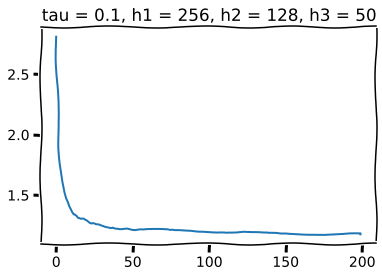

In [79]:

criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=200)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

In [80]:
import datetime
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet_simclr.h5"
print(filename)
resnet_simclr.save_weights(filename)

20201124-154539resnet_simclr.h5
